In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


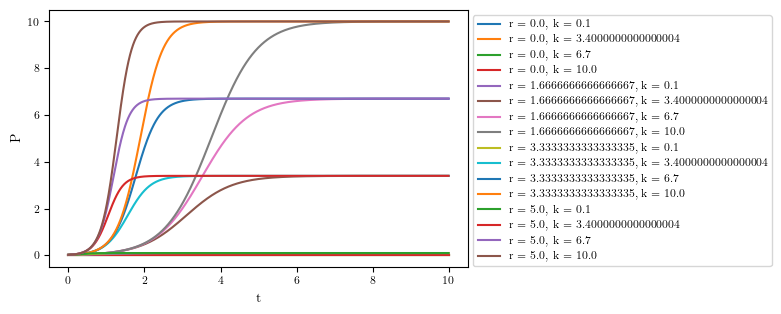

In [2]:
Nt=1000

K=np.linspace(0.1,10,4)
R=np.linspace(0,5,4)


P=np.zeros((Nt, len(R), len(K)))
T=np.zeros((Nt, len(R), len(K)))

for j in range(len(R)):
    for k in range(len(K)):
        dt=0.01
        P[0,j,k]=0.02 #Initial conditions
        T[0,j,k]=0
        for i in range(1,Nt):
            P[i,j,k]=P[i-1,j,k]+ P[i-1,j,k]*R[j]*(1-P[i-1,j,k]/K[k])*dt
            T[i,j,k]=T[i-1,j,k]+dt

        plt.plot(T[:,j,k],P[:,j,k], label='r = '+f'{R[j]}'+ ', k = '+f'{K[k]}')
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

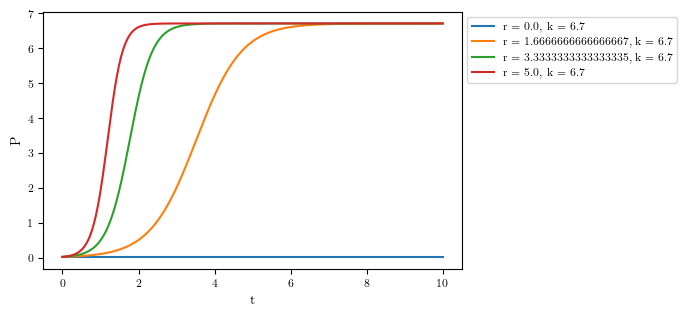

In [3]:
for j in range(len(R)):
    k=2
    plt.plot(T[:,j,k],P[:,j,k], label='r = '+f'{R[j]}'+ ', k = '+f'{K[k]}')
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [4]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net(t, r, w, b):
    p = DNN(tf.concat([t,r],1),  w, b)
    return p


#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, r, W_p, b_p, W_phi, b_phi):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        p=net(t, r, W_p, b_p)
        phi=net(p, r, W_phi, b_phi)
    p_t = tape1.gradient(p, t) 
    f = p_t - phi
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf, opt):
    t_u = X_u_train_tf[:,0:1]
    r_u = X_u_train_tf[:,1:2]
    t_f = X_f_train_tf[:,0:1]
    r_f = X_f_train_tf[:,1:2]


    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi])
        u_nn = net(t_u, r_u, W_p, b_p) 
        phi_nn = net(u_train_tf, r_u, W_phi, b_phi) 
        f_nn = net_f(t_f, r_f, W_p, b_p, W_phi, b_phi)
        loss_u = tf.reduce_mean(tf.square(u_nn - u_train_tf))
        loss_f = tf.reduce_mean(tf.square(f_nn)) 
        loss_phi = tf.reduce_mean(tf.square(phi_nn - r_u*u_train_tf*(1-u_train_tf/k_t)))
        loss =  loss_u + loss_f

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))

   
    return loss, loss_u, loss_f, loss_phi

In [5]:

# N_u = 100 # Number of Initial and Boundary data points
N_f = 100 # Number of residual point
N_d = 100 #Number of data

layers = [2, 50, 50, 1]
L = len(layers)

W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]
r = [tf.Variable(tf.zeros([1,1]), dtype=tf.float32)]
W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

2024-10-08 11:48:14.519901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-10-08 11:48:14.520206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-10-08 11:48:14.520483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-10-08 11:48:14.520775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-10-08 11:48:14.521049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-10-08 11:48:14.521327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

In [6]:
i=2

k_t=K[i]

t=T[:,0,0]
r=R[:,None]
Exact= P[:, :, i]

R_meshgrid,T_meshgrid = np.meshgrid(r,t)
X_star = np.hstack((T_meshgrid.flatten()[:,None], R_meshgrid.flatten()[:,None]))
P_star = Exact.flatten()[:,None]
u_star=np.hstack((P_star,R_meshgrid.flatten()[:,None]))
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

# # Initial Condition
# xx1 = np.hstack((T_meshgrid[0:1,:].T, R_meshgrid[0:1,:].T))
# uu1 = Exact[0:1,:].T


# Additional data
xxd = X_star
uud = P_star

np.random.seed(7)
idx=np.arange(len(uud))
np.random.shuffle(idx)

X_u_train = xxd[idx][::10]
u_train = uud[idx][::10]



X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
u_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32)


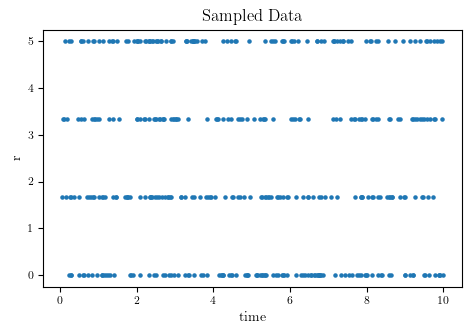

In [7]:
plt.title('Sampled Data')
plt.scatter(X_u_train_tf[:,0:1],X_u_train_tf[:,1:2], s=5)
plt.xlabel('time')
plt.ylabel('r')
plt.show()

In [8]:
lr = 1e-4
Nmax = 10**5
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_unk=[]
loss_fis=[]
while n <= Nmax:
    loss_, loss_u, loss_f, loss_phi = train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer)
    loss.append(loss_)
    loss_unk.append(loss_phi)
    loss_fis.append(loss_f)

    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_u}")
        print(f"Physicial loss is: {loss_f}")
        print(f"Function unknown loss is: {loss_phi}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 22.043249130249023
Data loss is: 21.64565658569336
Physicial loss is: 0.39759284257888794
Function unknown loss is: 1.2381079196929932
Iteration is: 10
Total loss is: 20.40209197998047
Data loss is: 20.160808563232422
Physicial loss is: 0.2412825971841812
Function unknown loss is: 1.280137300491333
Iteration is: 20
Total loss is: 18.56702995300293
Data loss is: 18.466459274291992
Physicial loss is: 0.10057021677494049
Function unknown loss is: 1.3772003650665283
Iteration is: 30
Total loss is: 16.784549713134766
Data loss is: 16.75821304321289
Physicial loss is: 0.026336543262004852
Function unknown loss is: 1.5221471786499023
Iteration is: 40
Total loss is: 15.20142936706543
Data loss is: 15.187838554382324
Physicial loss is: 0.013590998016297817
Function unknown loss is: 1.6570510864257812
Iteration is: 50
Total loss is: 13.826351165771484
Data loss is: 13.80490493774414
Physicial loss is: 0.02144618146121502
Function unknown loss is: 1.705052137374878


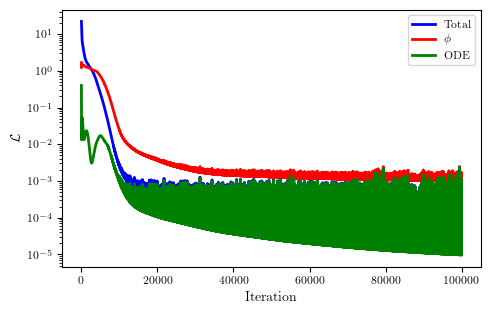

In [9]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_phi_list = [loss_unk[i].numpy() for i in range(0,Nmax)]
loss_f_list = [loss_fis[i].numpy() for i in range(0,Nmax)]


plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Total')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\phi$')    
plt.semilogy(it, np.asarray(loss_f_list), 'g-', linewidth = 2, label = 'ODE')       


plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [10]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    y_star = X_star_tf[:,1:2]
    u_pred = net(x_star, y_star, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)
error_u = np.linalg.norm(P_star-u_pred,2)/np.linalg.norm(u_pred,2)
print('Error u: %e' %(error_u))                     
Error = 100* np.linalg.norm(P_star - u_pred) / np.linalg.norm(u_pred)

# ## Evaluating unknown function
phi_pred = predict(u_star_tf, W_phi, b_phi)
phi_star=np.array(u_star_tf[:,1:2])*u_star_tf[:,0:1]*(1-u_star_tf[:,0:1]/k_t)
error_phi = np.linalg.norm(phi_star-phi_pred,2)/np.linalg.norm(phi_pred,2)
print('Error phi: %e' %(error_phi)) 
Error_phi = 100* np.linalg.norm(phi_star - phi_pred) / np.linalg.norm(phi_pred)

Error u: 9.194576e-04
Error phi: 2.250659e-02


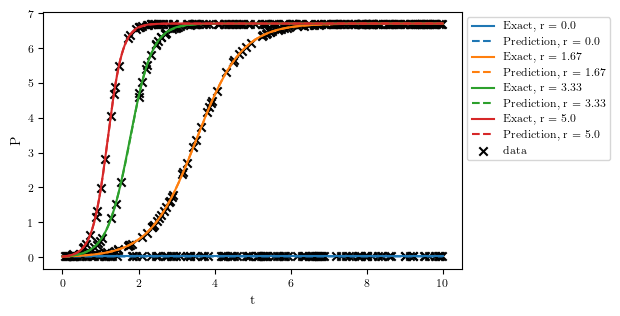

In [11]:
cmap = plt.get_cmap("tab10")  # O puedes usar otro colormap como "viridis"

# Crear figura
plt.figure()

for i in range(len(R)):
    color = cmap(i % 10)  # Usa % 10 para que no exceda el número de colores en el colormap
    # Graficar P_star con el mismo color
    plt.plot(X_star_tf[:,0:1][i::len(R)], P_star[i::len(R)], color=color, label='Exact, '+ f'r = {np.round(R[i],2)}')
    # Graficar u_pred con el mismo color
    plt.plot(X_star_tf[:,0:1][i::len(R)], u_pred[i::len(R)], linestyle='--', color=color, label='Prediction, '+ f'r = {np.round(R[i],2)}') 
    # # Graficar datos con el mismo color
plt.scatter(X_u_train_tf[:,0:1], u_train_tf, marker='x', color='black', label=f'data')  



# Mostrar leyenda
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

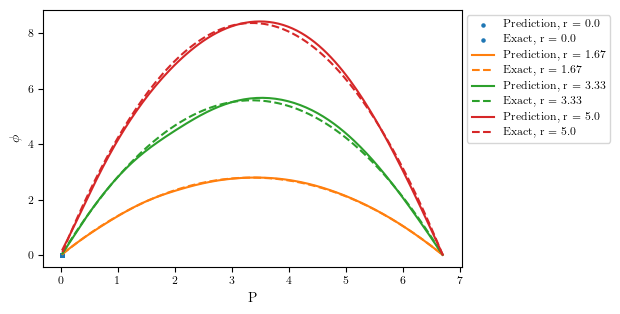

In [12]:
i=0
color = cmap(i % 10)
plt.scatter(P_star[i::len(R)], phi_pred[i::len(R)], color=color, s=5, label='Prediction, '+ f'r = {np.round(R[i],2)}')
plt.scatter(P_star[i::len(R)], phi_star[i::len(R)], color=color, s=5, label='Exact, '+ f'r = {np.round(R[i],2)}')

for i in range(1,len(R)):

    color = cmap(i % 10)
    plt.plot(P_star[i::len(R)], phi_pred[i::len(R)], color=color, label='Prediction, '+ f'r = {np.round(R[i],2)}')
    plt.plot(P_star[i::len(R)], phi_star[i::len(R)], color=color,linestyle='--', label='Exact, '+ f'r = {np.round(R[i],2)}')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel('P')
plt.ylabel('$\phi$')
# plt.savefig('figures/phi.pdf')
plt.show()

# Symbolic Regresion

In [51]:
# Create and train the PySR model
model_phi = PySRRegressor(
    niterations=40,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)

In [52]:
# Fit phi
model_phi.fit(u_star_tf, phi_pred)
print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.010e+04
Head worker occupation: 18.4%
Progress: 92 / 600 total iterations (15.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.622e+00  7.971e+00  y = inv(1.9905)
3           1.585e+00  2.297e-02  y = 0.17128 * x₁
5           1.571e+00  4.496e-03  y = (x₁ * 0.12122) + 0.19923
6           1.494e+00  5.047e-02  y = inv(2.0567 + x₀) * x₁
7           1.247e+00  1.804e-01  y = inv(x₀ + inv(x₀)) * x₁
8           1.204e+00  3.513e-02  y = inv(0.17128) * inv(x₀ + inv(x₀))
9           1.085e+00  1.039e-01  y = inv((x₀ + -1.1811) + inv(x₀)) * x₁
10          5.414e-01  6.956e-01  y = x₀ * (-1.4566 + (inv(x₀ + 1.486) * 12.161))
12          9.405e-04  3.178e+00  y = (((inv(x₀) + -0.1492) * x₀) * (x₁ * x₀)) + -0.0064077
14          9.319e-04  4.604e-03  y = (((inv(x₀) + -0.1492) * x₀) * ((0.0075088 + x₁) * x₀)) + -...
                    

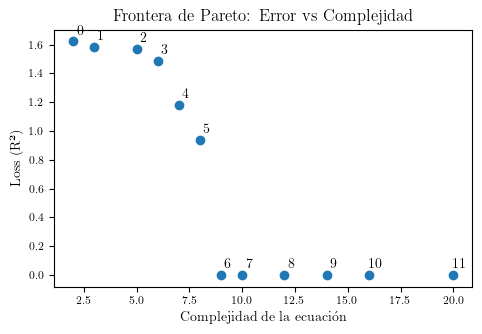

In [53]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

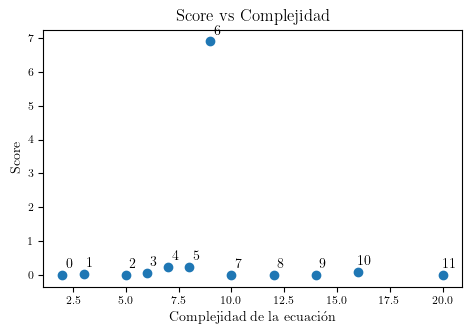

In [54]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [55]:
model_phi.sympy(6)

x0*(-0.14919965*x0*x1 + x1)

In [56]:
symb1=model_phi.predict(u_star_tf,6)

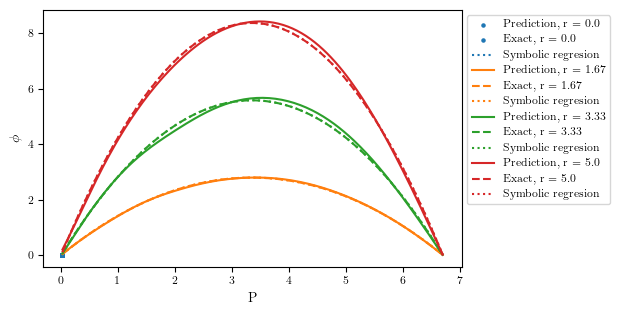

In [57]:
i=0
color = cmap(i % 10)
plt.scatter(P_star[i::len(R)], phi_pred[i::len(R)], color=color, s=5, label='Prediction, '+ f'r = {np.round(R[i],2)}')
plt.scatter(P_star[i::len(R)], phi_star[i::len(R)], color=color, s=5, label='Exact, '+ f'r = {np.round(R[i],2)}')
plt.plot(P_star[i::len(R)], symb1[i::len(R)], linestyle=':', label='Symbolic regresion')

for i in range(1,len(R)):

    color = cmap(i % 10)
    plt.plot(P_star[i::len(R)], phi_pred[i::len(R)], color=color, label='Prediction, '+ f'r = {np.round(R[i],2)}')
    plt.plot(P_star[i::len(R)], phi_star[i::len(R)], color=color,linestyle='--', label='Exact, '+ f'r = {np.round(R[i],2)}')
    plt.plot(P_star[i::len(R)], symb1[i::len(R)], linestyle=':', label='Symbolic regresion')


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel('P')
plt.ylabel('$\phi$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [58]:
# Create and train the PySR model
model_dPdT = PySRRegressor(
    niterations=20,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)


In [62]:
# Fit dP_dT
model_dPdT.fit(X_star_tf, u_pred)
print(model_dPdT)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1989: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.200e+04
Head worker occupation: 20.4%
Progress: 100 / 300 total iterations (33.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.787e+01  7.971e+00  y = inv(0.93282)
3           5.233e+00  1.228e+00  y = x₁ + 1.4468
5           3.625e+00  1.837e-01  y = x₁ + (0.33351 * x₀)
7           3.434e+00  2.700e-02  y = (x₀ * 0.4641) + (x₁ + -0.90581)
8           2.948e+00  1.524e-01  y = (inv(0.34908 + x₁) * x₀) * x₁
10          2.848e+00  1.732e-02  y = x₁ + inv(0.17494 + inv(x₀ + inv(-0.50158)))
12          2.205e+00  1.279e-01  y = exp((inv(exp(-2.0837) + x₁) * x₀) * 0.29378) * x₁
13          2.199e+00  3.053e-03  y = exp((inv(exp(inv(-0.41165)) + x₁) * x₀) * 0.29378) * x₁
14          2.104e+00  4.387e-02  y = x₁ * exp((x₀ * inv((exp(x₁) + -1.7725) + x₀)) * x₁)
15          1.173e+00  5.845e-01  y = x₁ + inv(exp(inv((x₁ * -0.30115) 

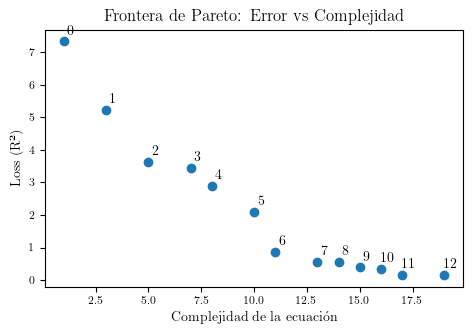

In [63]:
# Extraer las métricas de las ecuaciones
equations_df = model_dPdT.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

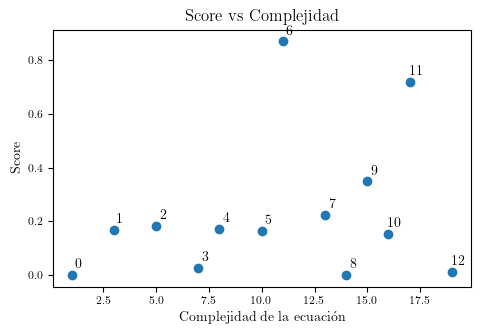

In [64]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [73]:
model_dPdT.sympy(11)

1.0543023 + 1/(0.12878644 + 1/(x0*x1 - 1.1359394))

In [76]:
symb2=model_dPdT.predict(X_star_tf,11)


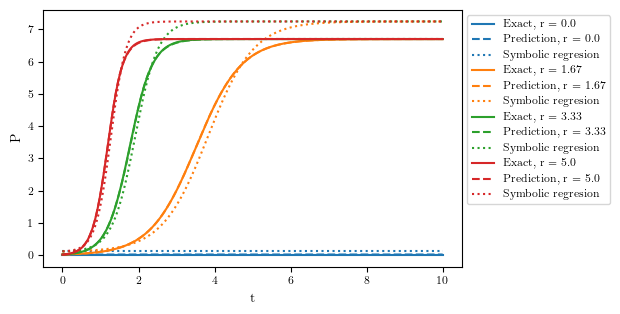

In [77]:
cmap = plt.get_cmap("tab10")  # O puedes usar otro colormap como "viridis"

# Crear figura
plt.figure()

for i in range(len(R)):
    color = cmap(i % 10)  # Usa % 10 para que no exceda el número de colores en el colormap
    # Graficar P_star con el mismo color
    plt.plot(X_star_tf[:,0:1][i::len(R)], P_star[i::len(R)], color=color, label='Exact, '+ f'r = {np.round(R[i],2)}')
    # Graficar u_pred con el mismo color
    plt.plot(X_star_tf[:,0:1][i::len(R)], u_pred[i::len(R)], linestyle='--', color=color, label='Prediction, '+ f'r = {np.round(R[i],2)}') 
    plt.plot(X_star_tf[:,0:1][i::len(R)], symb2[i::len(R)], linestyle=':', label='Symbolic regresion')



# Mostrar leyenda
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# Adding data

In [121]:
r_symb=np.linspace(0,5,10).reshape([-1,1])
R_meshgrid_symb,T_meshgrid_symb = np.meshgrid(r_symb,t[::10])

In [122]:
X_star_symb = np.hstack((T_meshgrid_symb.flatten()[:,None], R_meshgrid_symb.flatten()[:,None]))
X_star_symb_tf= tf.convert_to_tensor(X_star_symb, dtype=tf.float32)

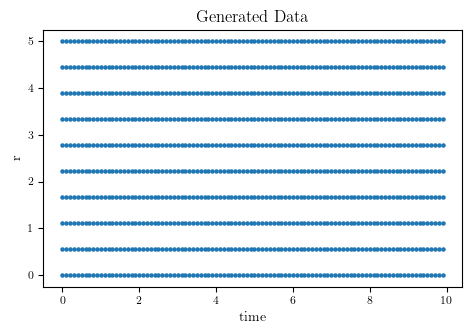

In [123]:
plt.title('Generated Data')
plt.scatter(X_star_symb[:,0:1],X_star_symb[:,1:2], s=5)
plt.xlabel('time')
plt.ylabel('r')
plt.show()

In [124]:
u_pred_symb = predict(X_star_symb_tf, W_p, b_p)

In [125]:
Nt=1000
k_t=K[2]


P_star_symb=np.zeros((Nt, len(r_symb)))
T_star_symb=np.zeros((Nt, len(r_symb)))

for j in range(len(r_symb)):
        dt=0.01
        P_star_symb[0,j]=0.02 #Initial conditions
        T_star_symb[0,j]=0
        for i in range(1,Nt):
            P_star_symb[i,j]=P_star_symb[i-1,j]+ P_star_symb[i-1,j]*r_symb[j]*(1-P_star_symb[i-1,j]/k_t)*dt
            T_star_symb[i,j]=T_star_symb[i-1,j]+dt

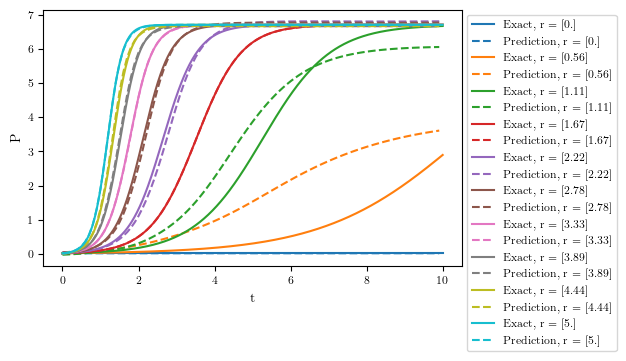

In [126]:
cmap = plt.get_cmap("tab10")  # O puedes usar otro colormap como "viridis"

# Crear figura
plt.figure()

for i in range(len(r_symb)):
    color = cmap(i % 10)  # Usa % 10 para que no exceda el número de colores en el colormap
    # Graficar P_star con el mismo color
    plt.plot(T_star_symb[:,i], P_star_symb[:,i], color=color, label='Exact, '+ f'r = {np.round(r_symb[i],2)}')
    # Graficar u_pred con el mismo color
    plt.plot(X_star_symb_tf[:,0:1][i::len(r_symb)], u_pred_symb[i::len(r_symb)], linestyle='--', color=color, label='Prediction, '+ f'r = {np.round(r_symb[i],2)}') 
    # # Graficar datos con el mismo color
# plt.scatter(X_u_train_tf[:,0:1], u_train_tf, marker='x', color='black', label=f'data')  



# Mostrar leyenda
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [127]:
# Create and train the PySR model
model_dPdT_data = PySRRegressor(
    niterations=50,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)

In [128]:
# Fit dP_dT
model_dPdT_data.fit(X_star_symb_tf, u_pred_symb)
print(model_dPdT_data)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.660e+05
Head worker occupation: 47.2%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 357 / 750 total iterations (47.600%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.313e+00  1.594e+01  y = x₁
2           8.205e+00  1.305e-02  y = exp(1.4396)
3           5.358e+00  4.263e-01  y = 1.7191 + x₁
5           3.037e+00  2.838e-01  y = x₁ + (0.40085 * x₀)
6           3.037e+00  -0.000e+00  y = x₁ + (inv(2.4947) * x₀)
7           2.760e+00  9.554e-02  y = -1.0443 + (x₁ + (x₀ * 0.55829))
9           2.752e+00  1.620e-03  y = ((x₁ * 1.0593) + (x₀ * 0.55829)) + -1.1925
10          2.206e+00  2.210e-01  y = 4.7437 + ((inv(x₀ + 2.2684) * -19.819) + x₁)
12          2.078e+00  2.992e-02  y = (4.7437 + ((inv(x₀ + 2.2684) * -19.819) + x₁)) * 1.0679
13        

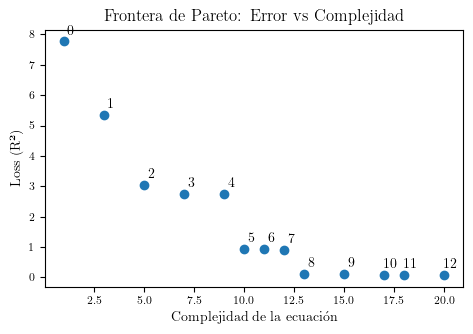

In [129]:
# Extraer las métricas de las ecuaciones
equations_df = model_dPdT_data.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

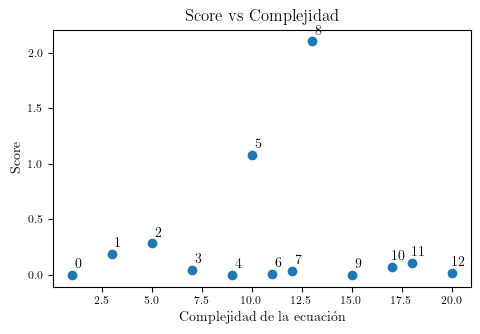

In [130]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [131]:
model_dPdT_data.sympy(8)

6.7455177 - 314.6875/(exp(0.69892794*x0*x1) + 45.328304)

In [132]:
symb_aug=model_dPdT_data.predict(X_star_symb_tf,8)


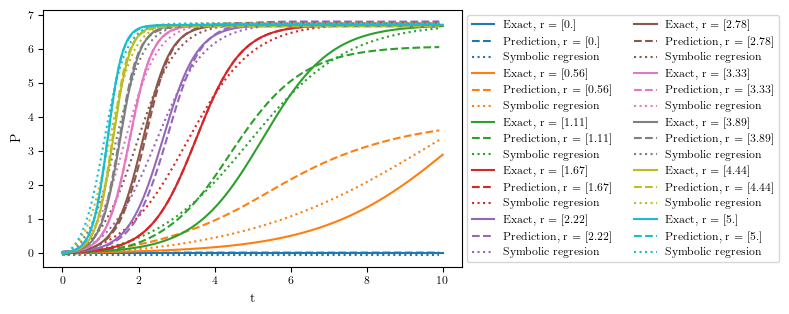

In [133]:
cmap = plt.get_cmap("tab10")  # O puedes usar otro colormap como "viridis"

# Crear figura
plt.figure()

for i in range(len(r_symb)):
    color = cmap(i % 10)  # Usa % 10 para que no exceda el número de colores en el colormap
    # Graficar P_star con el mismo color
    # plt.plot(X_star_symb_tf[:,0:1][i::len(R)], P_star[i::len(R)], color=color, label='Exact, '+ f'r = {np.round(R[i],2)}')
    # Graficar u_pred con el mismo color
    plt.plot(T_star_symb[:,i], P_star_symb[:,i], color=color, label='Exact, '+ f'r = {np.round(r_symb[i],2)}')
    plt.plot(X_star_symb_tf[:,0:1][i::len(r_symb)], u_pred_symb[i::len(r_symb)], linestyle='--', color=color, label='Prediction, '+ f'r = {np.round(r_symb[i],2)}') 
    plt.plot(X_star_symb_tf[:,0:1][i::len(r_symb)], symb_aug[i::len(r_symb)], linestyle=':', label='Symbolic regresion')



# Mostrar leyenda
plt.xlabel('t')
plt.ylabel('P')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)

plt.show()